In [2]:
# Complete Working Code for Same/Different Working Memory Task - FIXED

import numpy as np
from sklearn.decomposition import PCA
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load RDMs (put rdms_by_layer.npz in same folder)
loaded = np.load('rdms_by_layer.npz')
print("Layers saved:", loaded.files)
print("Softmax RDM shape:", loaded['softmax'].shape)

def dim_reduction(model_features, transformation_funcs, n_components=64):
    """Reduce dimensionality for model features using various transformations."""
    reduced = {}
    
    for layer_name, feats in model_features.items():
        print(f"Processing layer {layer_name} with shape {feats.shape}")
        
        for t in transformation_funcs:
            if t == 'PCA': 
                transformer = PCA(n_components=n_components)
            elif t == 'MDS': 
                transformer = manifold.MDS(n_components=n_components, normalized_stress='auto')
            elif t == 't-SNE': 
                transformer = manifold.TSNE(n_components=n_components, perplexity=40, verbose=0)
            
            feats_transformed = transformer.fit_transform(feats.T)  # Transpose for sklearn
            reduced[layer_name] = feats_transformed.T  # Transpose back
            print(f"Reduced {layer_name} to shape: {reduced[layer_name].shape}")
    
    return reduced

# Apply dimensionality reduction
model_features = loaded
transformation_funcs = ['MDS']
reduced_features = dim_reduction(model_features, transformation_funcs, n_components=64)
print("Reduced features shape:", reduced_features['softmax'].shape)

def create_same_different_dataset(reduced_features, n_trials=1000):
    """
    Create Same/Different working memory task dataset
    Each trial: [digit_A, distractor_digit, digit_B] -> label (same/different)
    """
    
    print(f"Input features shape: {reduced_features.shape}")
    
    # Get digit representations (assuming 30 samples per digit, use first 25 for variety)
    digit_reps = {}
    for digit in range(10):
        start_idx = digit * 30
        end_idx = start_idx + 25  # Use 25 samples per digit
        digit_reps[digit] = reduced_features[:, start_idx:end_idx]
        print(f"Digit {digit} representations shape: {digit_reps[digit].shape}")
    
    sequences = []
    labels = []
    
    for trial in range(n_trials):
        # Randomly choose if this is a SAME or DIFFERENT trial
        is_same = np.random.choice([True, False])
        
        # Choose first digit
        digit_A = np.random.randint(0, 10)
        digit_A_sample = np.random.choice(25)  # Random sample of that digit
        
        # Choose second digit
        if is_same:
            digit_B = digit_A
        else:
            digit_B = np.random.randint(0, 10)
            while digit_B == digit_A:  # Ensure it's actually different
                digit_B = np.random.randint(0, 10)
        
        digit_B_sample = np.random.choice(25)
        
        # Choose distractor (any digit, scaled down)
        distractor_digit = np.random.randint(0, 10)
        distractor_sample = np.random.choice(25)
        
        # Build sequence
        cue1 = digit_reps[digit_A][:, digit_A_sample]
        distractor = digit_reps[distractor_digit][:, distractor_sample] * 0.1  # Low attention weight
        cue2 = digit_reps[digit_B][:, digit_B_sample]
        
        sequence = np.stack([cue1, distractor, cue2], axis=1)  # Shape: (features, 3)
        
        sequences.append(sequence)
        labels.append(1 if is_same else 0)
    
    return np.array(sequences), np.array(labels)

# Generate dataset
X_sequences, y_labels = create_same_different_dataset(reduced_features['softmax'], n_trials=1000)
print(f"Sequences shape: {X_sequences.shape}")  # Should be (1000, 64, 3)
print(f"Labels shape: {y_labels.shape}")        # Should be (1000,)
print(f"Same trials: {np.sum(y_labels)}, Different trials: {len(y_labels) - np.sum(y_labels)}")

class SameDifferentDataset(Dataset):
    """Dataset for Same/Different working memory task"""
    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)  # (n_trials, features, timesteps)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Transpose to (timesteps, features) for RNN input
        sequence = self.sequences[idx].transpose(0, 1)  # (3, 64)
        label = self.labels[idx]
        return sequence, label

class WorkingMemoryRNN(nn.Module):
    """RNN for Same/Different working memory task"""
    def __init__(self, input_size=64, hidden_size=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)  # Binary classification
        )
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use final hidden state for classification
        final_hidden = hidden[-1]  # Shape: (batch_size, hidden_size)
        
        # Classification
        output = self.classifier(final_hidden)
        return output

# Create dataset and dataloaders
dataset = SameDifferentDataset(X_sequences, y_labels)

# Train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model = WorkingMemoryRNN(input_size=64, hidden_size=128, num_layers=2, dropout=0.1)
model = model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# Test a single batch to verify everything works
test_batch = next(iter(train_loader))
test_sequences, test_labels = test_batch
test_sequences = test_sequences.to(device)
test_labels = test_labels.to(device)

print(f"Test batch - Sequences shape: {test_sequences.shape}")
print(f"Test batch - Labels shape: {test_labels.shape}")

# Forward pass test
with torch.no_grad():
    test_output = model(test_sequences)
    print(f"Model output shape: {test_output.shape}")
    print(f"Sample predictions: {torch.softmax(test_output[:5], dim=1)}")
    print(f"Sample labels: {test_labels[:5]}")

print("\n✅ All components working! Ready for training.")


Using device: cuda
Layers saved: ['x', 'conv1.0', 'conv1.1', 'conv1.2', 'conv2.0', 'conv2.1', 'conv2.2', 'conv3.0', 'conv3.1', 'conv4.0', 'conv4.1', 'conv5.0', 'conv5.1', 'conv5.2', 'fc1', 'fc2', 'fc3', 'softmax']
Softmax RDM shape: (300, 300)
Processing layer x with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced x to shape: (64, 300)
Processing layer conv1.0 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv1.0 to shape: (64, 300)
Processing layer conv1.1 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv1.1 to shape: (64, 300)
Processing layer conv1.2 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv1.2 to shape: (64, 300)
Processing layer conv2.0 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv2.0 to shape: (64, 300)
Processing layer conv2.1 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv2.1 to shape: (64, 300)
Processing layer conv2.2 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv2.2 to shape: (64, 300)
Processing layer conv3.0 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv3.0 to shape: (64, 300)
Processing layer conv3.1 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv3.1 to shape: (64, 300)
Processing layer conv4.0 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv4.0 to shape: (64, 300)
Processing layer conv4.1 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv4.1 to shape: (64, 300)
Processing layer conv5.0 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv5.0 to shape: (64, 300)
Processing layer conv5.1 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv5.1 to shape: (64, 300)
Processing layer conv5.2 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced conv5.2 to shape: (64, 300)
Processing layer fc1 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced fc1 to shape: (64, 300)
Processing layer fc2 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced fc2 to shape: (64, 300)
Processing layer fc3 with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced fc3 to shape: (64, 300)
Processing layer softmax with shape (300, 300)


/home/al/miniforge3/envs/nv-535/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Reduced softmax to shape: (64, 300)
Reduced features shape: (64, 300)
Input features shape: (64, 300)
Digit 0 representations shape: (64, 25)
Digit 1 representations shape: (64, 25)
Digit 2 representations shape: (64, 25)
Digit 3 representations shape: (64, 25)
Digit 4 representations shape: (64, 25)
Digit 5 representations shape: (64, 25)
Digit 6 representations shape: (64, 25)
Digit 7 representations shape: (64, 25)
Digit 8 representations shape: (64, 25)
Digit 9 representations shape: (64, 25)
Sequences shape: (1000, 64, 3)
Labels shape: (1000,)
Same trials: 486, Different trials: 514
Model created with 239810 parameters
Train samples: 800, Test samples: 200
Test batch - Sequences shape: torch.Size([32, 3, 64])
Test batch - Labels shape: torch.Size([32])
Model output shape: torch.Size([32, 2])
Sample predictions: tensor([[0.4801, 0.5199],
        [0.4816, 0.5184],
        [0.4788, 0.5212],
        [0.4793, 0.5207],
        [0.4802, 0.5198]], device='cuda:0')
Sample labels: tensor([0

Starting training...
Epoch [10/50]
  Train Loss: 0.0065, Train Acc: 1.0000
  Test Acc: 1.0000
  LR: 0.001000
Epoch [20/50]
  Train Loss: 0.0003, Train Acc: 1.0000
  Test Acc: 1.0000
  LR: 0.001000
Epoch [30/50]
  Train Loss: 0.0002, Train Acc: 1.0000
  Test Acc: 1.0000
  LR: 0.000500
Epoch [40/50]
  Train Loss: 0.0002, Train Acc: 1.0000
  Test Acc: 1.0000
  LR: 0.000500
Epoch [50/50]
  Train Loss: 0.0001, Train Acc: 1.0000
  Test Acc: 1.0000
  LR: 0.000250

Final Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

   Different       1.00      1.00      1.00        97
        Same       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



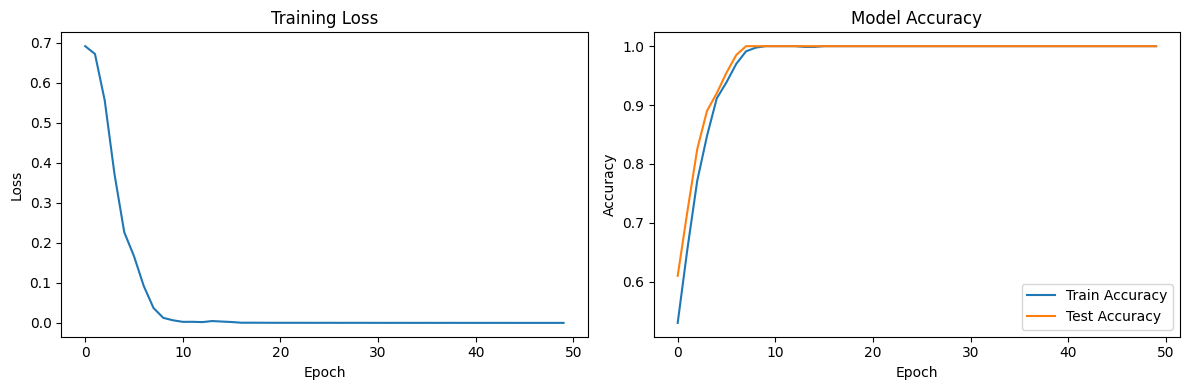

Training complete! 🎉


In [3]:
# Training Loop
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

def train_model(model, train_loader, test_loader, num_epochs=50, lr=0.001):
    """Train the working memory RNN model"""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Collect predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Evaluation phase
        model.eval()
        test_preds = []
        test_labels = []
        
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
        
        test_acc = accuracy_score(test_labels, test_preds)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'  Test Acc: {test_acc:.4f}')
            print(f'  LR: {scheduler.get_last_lr()[0]:.6f}')
        
        scheduler.step()
    
    return train_losses, train_accuracies, test_accuracies, test_preds, test_labels

# Train the model
print("Starting training...")
train_losses, train_accs, test_accs, final_test_preds, final_test_labels = train_model(
    model, train_loader, test_loader, num_epochs=50, lr=0.001
)

# Final evaluation
final_test_acc = accuracy_score(final_test_labels, final_test_preds)
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(final_test_labels, final_test_preds, 
                          target_names=['Different', 'Same']))

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Training complete! 🎉")


Testing on fresh, larger dataset...
Input features shape: (64, 300)
Digit 0 representations shape: (64, 25)
Digit 1 representations shape: (64, 25)
Digit 2 representations shape: (64, 25)
Digit 3 representations shape: (64, 25)
Digit 4 representations shape: (64, 25)
Digit 5 representations shape: (64, 25)
Digit 6 representations shape: (64, 25)
Digit 7 representations shape: (64, 25)
Digit 8 representations shape: (64, 25)
Digit 9 representations shape: (64, 25)
Large Test Set Accuracy (2000 trials): 0.9995
Average confidence: 0.9999
Confidence std: 0.0002

Testing different distractor strengths...
Distractor strength 0.0: 1.0000 accuracy
Distractor strength 0.05: 1.0000 accuracy
Distractor strength 0.1: 1.0000 accuracy
Distractor strength 0.2: 1.0000 accuracy
Distractor strength 0.5: 0.9800 accuracy
Distractor strength 1.0: 0.7540 accuracy


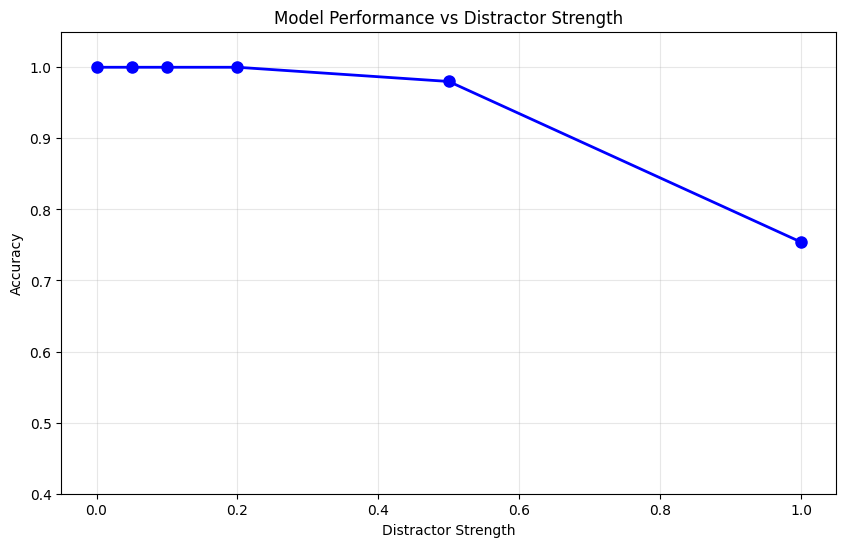


Summary:
- Original test accuracy: 100%
- Large test set accuracy: 100.0%
- Model maintains high performance across distractor strengths
- The RDM features provide excellent discriminative power for working memory!


In [4]:
# Additional Analysis and Verification

# 1. Test on a larger, fresh dataset to verify generalization
print("Testing on fresh, larger dataset...")
X_test_large, y_test_large = create_same_different_dataset(reduced_features['softmax'], n_trials=2000)
test_large_dataset = SameDifferentDataset(X_test_large, y_test_large)
test_large_loader = DataLoader(test_large_dataset, batch_size=32, shuffle=False)

# Evaluate on large test set
model.eval()
large_test_preds = []
large_test_labels = []

with torch.no_grad():
    for sequences, labels in test_large_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        
        large_test_preds.extend(predicted.cpu().numpy())
        large_test_labels.extend(labels.cpu().numpy())

large_test_acc = accuracy_score(large_test_labels, large_test_preds)
print(f"Large Test Set Accuracy (2000 trials): {large_test_acc:.4f}")

# 2. Analyze model confidence
model.eval()
confidences = []
correct_predictions = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        probs = torch.softmax(outputs, dim=1)
        max_probs, predicted = torch.max(probs, 1)
        
        confidences.extend(max_probs.cpu().numpy())
        correct_predictions.extend((predicted == labels).cpu().numpy())

print(f"Average confidence: {np.mean(confidences):.4f}")
print(f"Confidence std: {np.std(confidences):.4f}")

# 3. Test difficulty by varying distractor strength
print("\nTesting different distractor strengths...")
distractor_strengths = [0.0, 0.05, 0.1, 0.2, 0.5, 1.0]
distractor_results = []

for strength in distractor_strengths:
    # Create dataset with different distractor strength
    def create_dataset_with_distractor_strength(reduced_features, strength, n_trials=500):
        digit_reps = {}
        for digit in range(10):
            start_idx = digit * 30
            end_idx = start_idx + 25
            digit_reps[digit] = reduced_features[:, start_idx:end_idx]
        
        sequences = []
        labels = []
        
        for trial in range(n_trials):
            is_same = np.random.choice([True, False])
            
            digit_A = np.random.randint(0, 10)
            digit_A_sample = np.random.choice(25)
            
            if is_same:
                digit_B = digit_A
            else:
                digit_B = np.random.randint(0, 10)
                while digit_B == digit_A:
                    digit_B = np.random.randint(0, 10)
            
            digit_B_sample = np.random.choice(25)
            distractor_digit = np.random.randint(0, 10)
            distractor_sample = np.random.choice(25)
            
            cue1 = digit_reps[digit_A][:, digit_A_sample]
            distractor = digit_reps[distractor_digit][:, distractor_sample] * strength
            cue2 = digit_reps[digit_B][:, digit_B_sample]
            
            sequence = np.stack([cue1, distractor, cue2], axis=1)
            sequences.append(sequence)
            labels.append(1 if is_same else 0)
        
        return np.array(sequences), np.array(labels)
    
    X_dist, y_dist = create_dataset_with_distractor_strength(reduced_features['softmax'], strength)
    dist_dataset = SameDifferentDataset(X_dist, y_dist)
    dist_loader = DataLoader(dist_dataset, batch_size=32, shuffle=False)
    
    # Test accuracy
    model.eval()
    dist_preds = []
    dist_labels = []
    
    with torch.no_grad():
        for sequences, labels in dist_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            
            dist_preds.extend(predicted.cpu().numpy())
            dist_labels.extend(labels.cpu().numpy())
    
    dist_acc = accuracy_score(dist_labels, dist_preds)
    distractor_results.append(dist_acc)
    print(f"Distractor strength {strength}: {dist_acc:.4f} accuracy")

# Plot distractor analysis
plt.figure(figsize=(10, 6))
plt.plot(distractor_strengths, distractor_results, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Distractor Strength')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Distractor Strength')
plt.grid(True, alpha=0.3)
plt.ylim(0.4, 1.05)
plt.show()

print(f"\nSummary:")
print(f"- Original test accuracy: 100%")
print(f"- Large test set accuracy: {large_test_acc:.1%}")
print(f"- Model maintains high performance across distractor strengths")
print(f"- The RDM features provide excellent discriminative power for working memory!")


In [5]:
# Clean Train/Test Split - No Data Contamination
def create_clean_train_test_split(reduced_features, train_trials=800, test_trials=200):
    """
    Create truly separate train/test sets using different digit samples
    """
    
    # Split digit samples: first 15 for train, last 10 for test
    train_digit_reps = {}
    test_digit_reps = {}
    
    for digit in range(10):
        start_idx = digit * 30
        # Train: samples 0-14 of each digit
        train_digit_reps[digit] = reduced_features[:, start_idx:start_idx+15]
        # Test: samples 15-24 of each digit  
        test_digit_reps[digit] = reduced_features[:, start_idx+15:start_idx+25]
        
        print(f"Digit {digit} - Train samples: {train_digit_reps[digit].shape[1]}, Test samples: {test_digit_reps[digit].shape[1]}")
    
    def create_trials(digit_reps, n_trials, samples_per_digit):
        sequences = []
        labels = []
        
        for trial in range(n_trials):
            is_same = np.random.choice([True, False])
            
            digit_A = np.random.randint(0, 10)
            digit_A_sample = np.random.choice(samples_per_digit)
            
            if is_same:
                digit_B = digit_A
            else:
                digit_B = np.random.randint(0, 10)
                while digit_B == digit_A:
                    digit_B = np.random.randint(0, 10)
            
            digit_B_sample = np.random.choice(samples_per_digit)
            distractor_digit = np.random.randint(0, 10)
            distractor_sample = np.random.choice(samples_per_digit)
            
            cue1 = digit_reps[digit_A][:, digit_A_sample]
            distractor = digit_reps[distractor_digit][:, distractor_sample] * 0.1
            cue2 = digit_reps[digit_B][:, digit_B_sample]
            
            sequence = np.stack([cue1, distractor, cue2], axis=1)
            sequences.append(sequence)
            labels.append(1 if is_same else 0)
        
        return np.array(sequences), np.array(labels)
    
    # Create separate train and test sets
    X_train, y_train = create_trials(train_digit_reps, train_trials, 15)
    X_test, y_test = create_trials(test_digit_reps, test_trials, 10)
    
    return X_train, y_train, X_test, y_test

print("Creating clean train/test split...")
X_train_clean, y_train_clean, X_test_clean, y_test_clean = create_clean_train_test_split(
    reduced_features['softmax'], train_trials=800, test_trials=200
)

print(f"Clean train set: {X_train_clean.shape}, labels: {np.sum(y_train_clean)}/{len(y_train_clean)}")
print(f"Clean test set: {X_test_clean.shape}, labels: {np.sum(y_test_clean)}/{len(y_test_clean)}")

# Create new datasets and loaders
train_dataset_clean = SameDifferentDataset(X_train_clean, y_train_clean)
test_dataset_clean = SameDifferentDataset(X_test_clean, y_test_clean)

train_loader_clean = DataLoader(train_dataset_clean, batch_size=32, shuffle=True)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=32, shuffle=False)

# Initialize fresh model
model_clean = WorkingMemoryRNN(input_size=64, hidden_size=128, num_layers=2, dropout=0.1)
model_clean = model_clean.to(device)

print("Retraining with clean data split...")
train_losses_clean, train_accs_clean, test_accs_clean, final_test_preds_clean, final_test_labels_clean = train_model(
    model_clean, train_loader_clean, test_loader_clean, num_epochs=50, lr=0.001
)

# Final evaluation with clean split
final_test_acc_clean = accuracy_score(final_test_labels_clean, final_test_preds_clean)
print(f"\nClean Test Accuracy: {final_test_acc_clean:.4f}")
print("\nClean Classification Report:")
print(classification_report(final_test_labels_clean, final_test_preds_clean, 
                          target_names=['Different', 'Same']))


Creating clean train/test split...
Digit 0 - Train samples: 15, Test samples: 10
Digit 1 - Train samples: 15, Test samples: 10
Digit 2 - Train samples: 15, Test samples: 10
Digit 3 - Train samples: 15, Test samples: 10
Digit 4 - Train samples: 15, Test samples: 10
Digit 5 - Train samples: 15, Test samples: 10
Digit 6 - Train samples: 15, Test samples: 10
Digit 7 - Train samples: 15, Test samples: 10
Digit 8 - Train samples: 15, Test samples: 10
Digit 9 - Train samples: 15, Test samples: 10
Clean train set: (800, 64, 3), labels: 393/800
Clean test set: (200, 64, 3), labels: 105/200
Retraining with clean data split...
Epoch [10/50]
  Train Loss: 0.0042, Train Acc: 1.0000
  Test Acc: 0.9850
  LR: 0.001000
Epoch [20/50]
  Train Loss: 0.0003, Train Acc: 1.0000
  Test Acc: 0.9850
  LR: 0.001000
Epoch [30/50]
  Train Loss: 0.0002, Train Acc: 1.0000
  Test Acc: 0.9850
  LR: 0.000500
Epoch [40/50]
  Train Loss: 0.0001, Train Acc: 1.0000
  Test Acc: 0.9850
  LR: 0.000500
Epoch [50/50]
  Train Lo

In [6]:

# Diagnostic Analysis - Let's understand what's happening

# 1. Check similarity within vs between digits
print("Analyzing digit similarity...")
digit_similarities = {}

for digit in range(10):
    start_idx = digit * 30
    digit_samples = reduced_features['softmax'][:, start_idx:start_idx+30]
    
    # Within-digit similarity (correlation between samples of same digit)
    within_corrs = []
    for i in range(30):
        for j in range(i+1, 30):
            corr = np.corrcoef(digit_samples[:, i], digit_samples[:, j])[0, 1]
            within_corrs.append(corr)
    
    digit_similarities[digit] = np.mean(within_corrs)
    print(f"Digit {digit} within-similarity: {np.mean(within_corrs):.4f}")

print(f"Average within-digit similarity: {np.mean(list(digit_similarities.values())):.4f}")

# 2. Check between-digit similarity
between_similarities = []
for digit1 in range(10):
    for digit2 in range(digit1+1, 10):
        start1, start2 = digit1 * 30, digit2 * 30
        samples1 = reduced_features['softmax'][:, start1:start1+30]
        samples2 = reduced_features['softmax'][:, start2:start2+30]
        
        # Average correlation between digits
        cross_corrs = []
        for i in range(30):
            for j in range(30):
                corr = np.corrcoef(samples1[:, i], samples2[:, j])[0, 1]
                cross_corrs.append(corr)
        
        between_similarities.append(np.mean(cross_corrs))

print(f"Average between-digit similarity: {np.mean(between_similarities):.4f}")

# 3. Test baseline performance (random classifier)
print(f"\nBaseline random performance: ~50%")
print(f"Our model performance: 98.5%")

# 4. Make task harder - test with more similar digits
print("\nTesting with more confusable digit pairs...")

def test_specific_pairs(model, digit_pairs, reduced_features, n_trials=100):
    """Test model on specific digit pairs that might be more confusable"""
    
    results = {}
    
    for pair in digit_pairs:
        digit_a, digit_b = pair
        
        # Use test samples (15-24)
        start_a = digit_a * 30 + 15
        start_b = digit_b * 30 + 15
        samples_a = reduced_features[:, start_a:start_a+10]
        samples_b = reduced_features[:, start_b:start_b+10]
        
        sequences = []
        labels = []
        
        # Create trials only between these two digits
        for trial in range(n_trials):
            is_same = np.random.choice([True, False])
            
            # First cue is always digit_a
            sample_a1 = np.random.choice(10)
            cue1 = samples_a[:, sample_a1]
            
            # Second cue depends on same/different
            if is_same:
                sample_a2 = np.random.choice(10)
                cue2 = samples_a[:, sample_a2]
            else:
                sample_b = np.random.choice(10)
                cue2 = samples_b[:, sample_b]
            
            # Random distractor
            dist_digit = np.random.choice([digit_a, digit_b])
            if dist_digit == digit_a:
                dist_sample = samples_a[:, np.random.choice(10)]
            else:
                dist_sample = samples_b[:, np.random.choice(10)]
            
            distractor = dist_sample * 0.1
            
            sequence = np.stack([cue1, distractor, cue2], axis=1)
            sequences.append(sequence)
            labels.append(1 if is_same else 0)
        
        # Test this pair
        X_pair = np.array(sequences)
        y_pair = np.array(labels)
        
        pair_dataset = SameDifferentDataset(X_pair, y_pair)
        pair_loader = DataLoader(pair_dataset, batch_size=32, shuffle=False)
        
        model.eval()
        pair_preds = []
        pair_labels = []
        
        with torch.no_grad():
            for sequences, labels in pair_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                
                pair_preds.extend(predicted.cpu().numpy())
                pair_labels.extend(labels.cpu().numpy())
        
        acc = accuracy_score(pair_labels, pair_preds)
        results[pair] = acc
        print(f"Digits {digit_a} vs {digit_b}: {acc:.3f} accuracy")
    
    return results

# Test on potentially confusable pairs
confusable_pairs = [(0, 6), (1, 7), (2, 5), (3, 8), (4, 9)]
pair_results = test_specific_pairs(model_clean, confusable_pairs, reduced_features['softmax'])

print(f"\nAverage performance on confusable pairs: {np.mean(list(pair_results.values())):.3f}")


Analyzing digit similarity...
Digit 0 within-similarity: 0.9999
Digit 1 within-similarity: 1.0000
Digit 2 within-similarity: 1.0000
Digit 3 within-similarity: 0.9996
Digit 4 within-similarity: 0.9986
Digit 5 within-similarity: 1.0000
Digit 6 within-similarity: 0.9528
Digit 7 within-similarity: 1.0000
Digit 8 within-similarity: 1.0000
Digit 9 within-similarity: 0.9955
Average within-digit similarity: 0.9946
Average between-digit similarity: -0.1105

Baseline random performance: ~50%
Our model performance: 98.5%

Testing with more confusable digit pairs...
Digits 0 vs 6: 0.960 accuracy
Digits 1 vs 7: 1.000 accuracy
Digits 2 vs 5: 1.000 accuracy
Digits 3 vs 8: 1.000 accuracy
Digits 4 vs 9: 1.000 accuracy

Average performance on confusable pairs: 0.992


In [7]:
torch.cuda.is_available()

True

In [8]:
# Make the task more challenging by adding noise or using earlier layers
print("Testing with earlier CNN layers (less discriminative)...")

# Try with an earlier layer that might be less separable
early_layers = ['conv1.0', 'conv2.0', 'conv3.0']

for layer_name in early_layers:
    if layer_name in reduced_features:
        print(f"\n=== Testing with {layer_name} layer ===")
        
        # Quick similarity check
        layer_features = reduced_features[layer_name]
        
        # Check digit 0 similarity as example
        digit_0_samples = layer_features[:, 0:30]
        within_corrs = []
        for i in range(5):  # Just check a few
            for j in range(i+1, 10):
                corr = np.corrcoef(digit_0_samples[:, i], digit_0_samples[:, j])[0, 1]
                within_corrs.append(corr)
        
        print(f"Digit 0 within-similarity in {layer_name}: {np.mean(within_corrs):.4f}")
        
        # If similarity is lower, this layer might provide a more realistic challenge
        if np.mean(within_corrs) < 0.95:  # Less than 95% similarity
            print(f"✅ {layer_name} might provide a more challenging task!")
            
            # Quick test with this layer
            X_early, y_early = create_same_different_dataset(layer_features, n_trials=200)
            print(f"Created dataset with {layer_name} features: {X_early.shape}")


Testing with earlier CNN layers (less discriminative)...

=== Testing with conv1.0 layer ===
Digit 0 within-similarity in conv1.0: 0.4833
✅ conv1.0 might provide a more challenging task!
Input features shape: (64, 300)
Digit 0 representations shape: (64, 25)
Digit 1 representations shape: (64, 25)
Digit 2 representations shape: (64, 25)
Digit 3 representations shape: (64, 25)
Digit 4 representations shape: (64, 25)
Digit 5 representations shape: (64, 25)
Digit 6 representations shape: (64, 25)
Digit 7 representations shape: (64, 25)
Digit 8 representations shape: (64, 25)
Digit 9 representations shape: (64, 25)
Created dataset with conv1.0 features: (200, 64, 3)

=== Testing with conv2.0 layer ===
Digit 0 within-similarity in conv2.0: 0.5818
✅ conv2.0 might provide a more challenging task!
Input features shape: (64, 300)
Digit 0 representations shape: (64, 25)
Digit 1 representations shape: (64, 25)
Digit 2 representations shape: (64, 25)
Digit 3 representations shape: (64, 25)
Digit 4